In [1]:
import os                                                    

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.util import montage
from skimage.transform import rotate

import keras
import tensorflow as tf
import keras.backend as K

from keras.models import Model
from keras.models import Sequential

import nibabel as nib 

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

from sklearn.model_selection import train_test_split

(181, 217, 181)
(181, 217, 181)
(181, 217, 181)
(181, 217, 181)
(181, 217, 181)


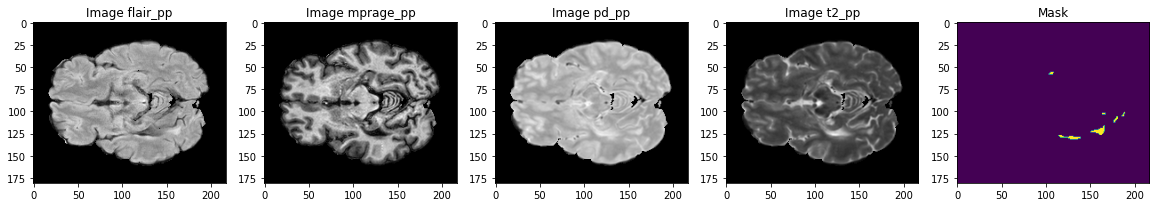

In [2]:
TRAIN_DATASET_PATH = '../input/mslsc-multiplesclerosis-lesion-segmentation/training'

test_image_flair_pp=nib.load(TRAIN_DATASET_PATH + '/training01/preprocessed/training01_01_flair_pp.nii').get_fdata()
test_image_mprage_pp=nib.load(TRAIN_DATASET_PATH + '/training01/preprocessed/training01_01_mprage_pp.nii').get_fdata()
test_image_pd_pp=nib.load(TRAIN_DATASET_PATH + '/training01/preprocessed/training01_01_pd_pp.nii').get_fdata()
test_image_t2_pp=nib.load(TRAIN_DATASET_PATH + '/training01/preprocessed/training01_01_t2_pp.nii').get_fdata()
test_image_Brain_Mask=nib.load(TRAIN_DATASET_PATH + '/training01/masks/training01_01_mask1.nii').get_fdata()
    

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w =25
ax1.imshow(test_image_flair_pp[:,:,test_image_flair_pp.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair_pp')
ax2.imshow(test_image_mprage_pp[:,:,test_image_mprage_pp.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image mprage_pp')
ax3.imshow(test_image_pd_pp[:,:,test_image_pd_pp.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image pd_pp')
ax4.imshow(test_image_t2_pp[:,:,test_image_t2_pp.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2_pp')
ax5.imshow(test_image_Brain_Mask[:,:,test_image_Brain_Mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

print(test_image_flair_pp.shape)
print(test_image_mprage_pp.shape)
print(test_image_pd_pp.shape)
print(test_image_t2_pp.shape)
print(test_image_Brain_Mask.shape)

In [3]:
SEGMENT_CLASSES = {
    0 : 'NOT_MS',
    1 : 'MS' }

total count: 517035


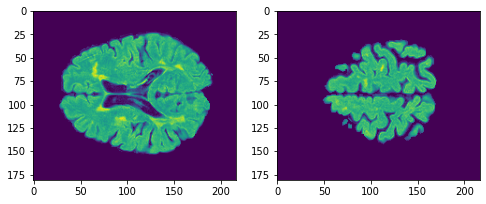

In [4]:
VOLUME_START_AT=90
VOLUME_SLICES=90

def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH + '/training02/preprocessed/training02_01_flair_pp.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 10))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

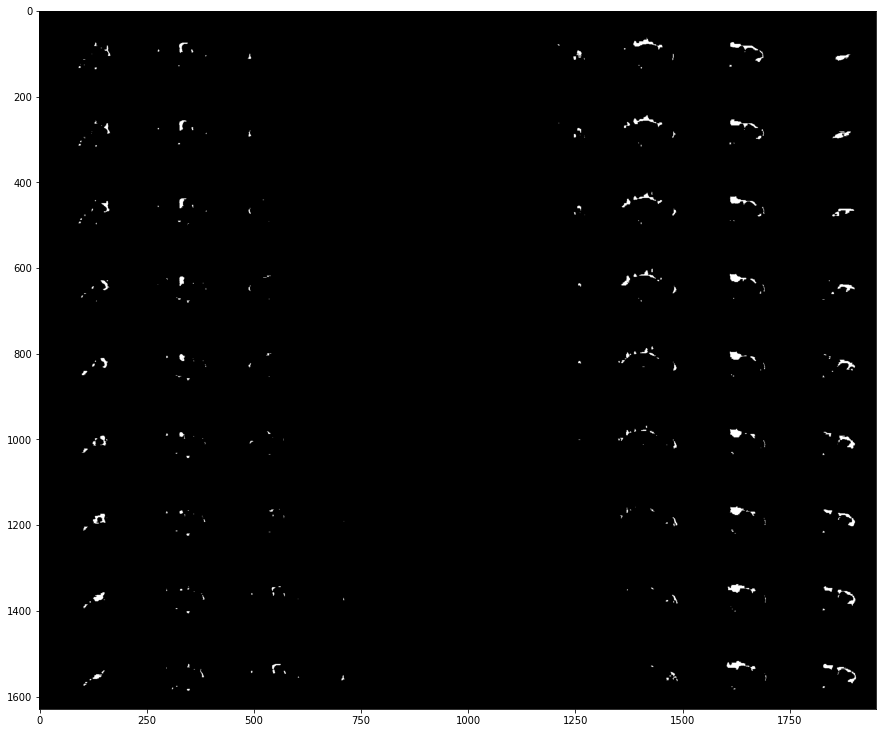

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,30))
ax1.imshow(rotate(montage(test_image_Brain_Mask[50:-50,:,:]), 90, resize=True), cmap ='gray');

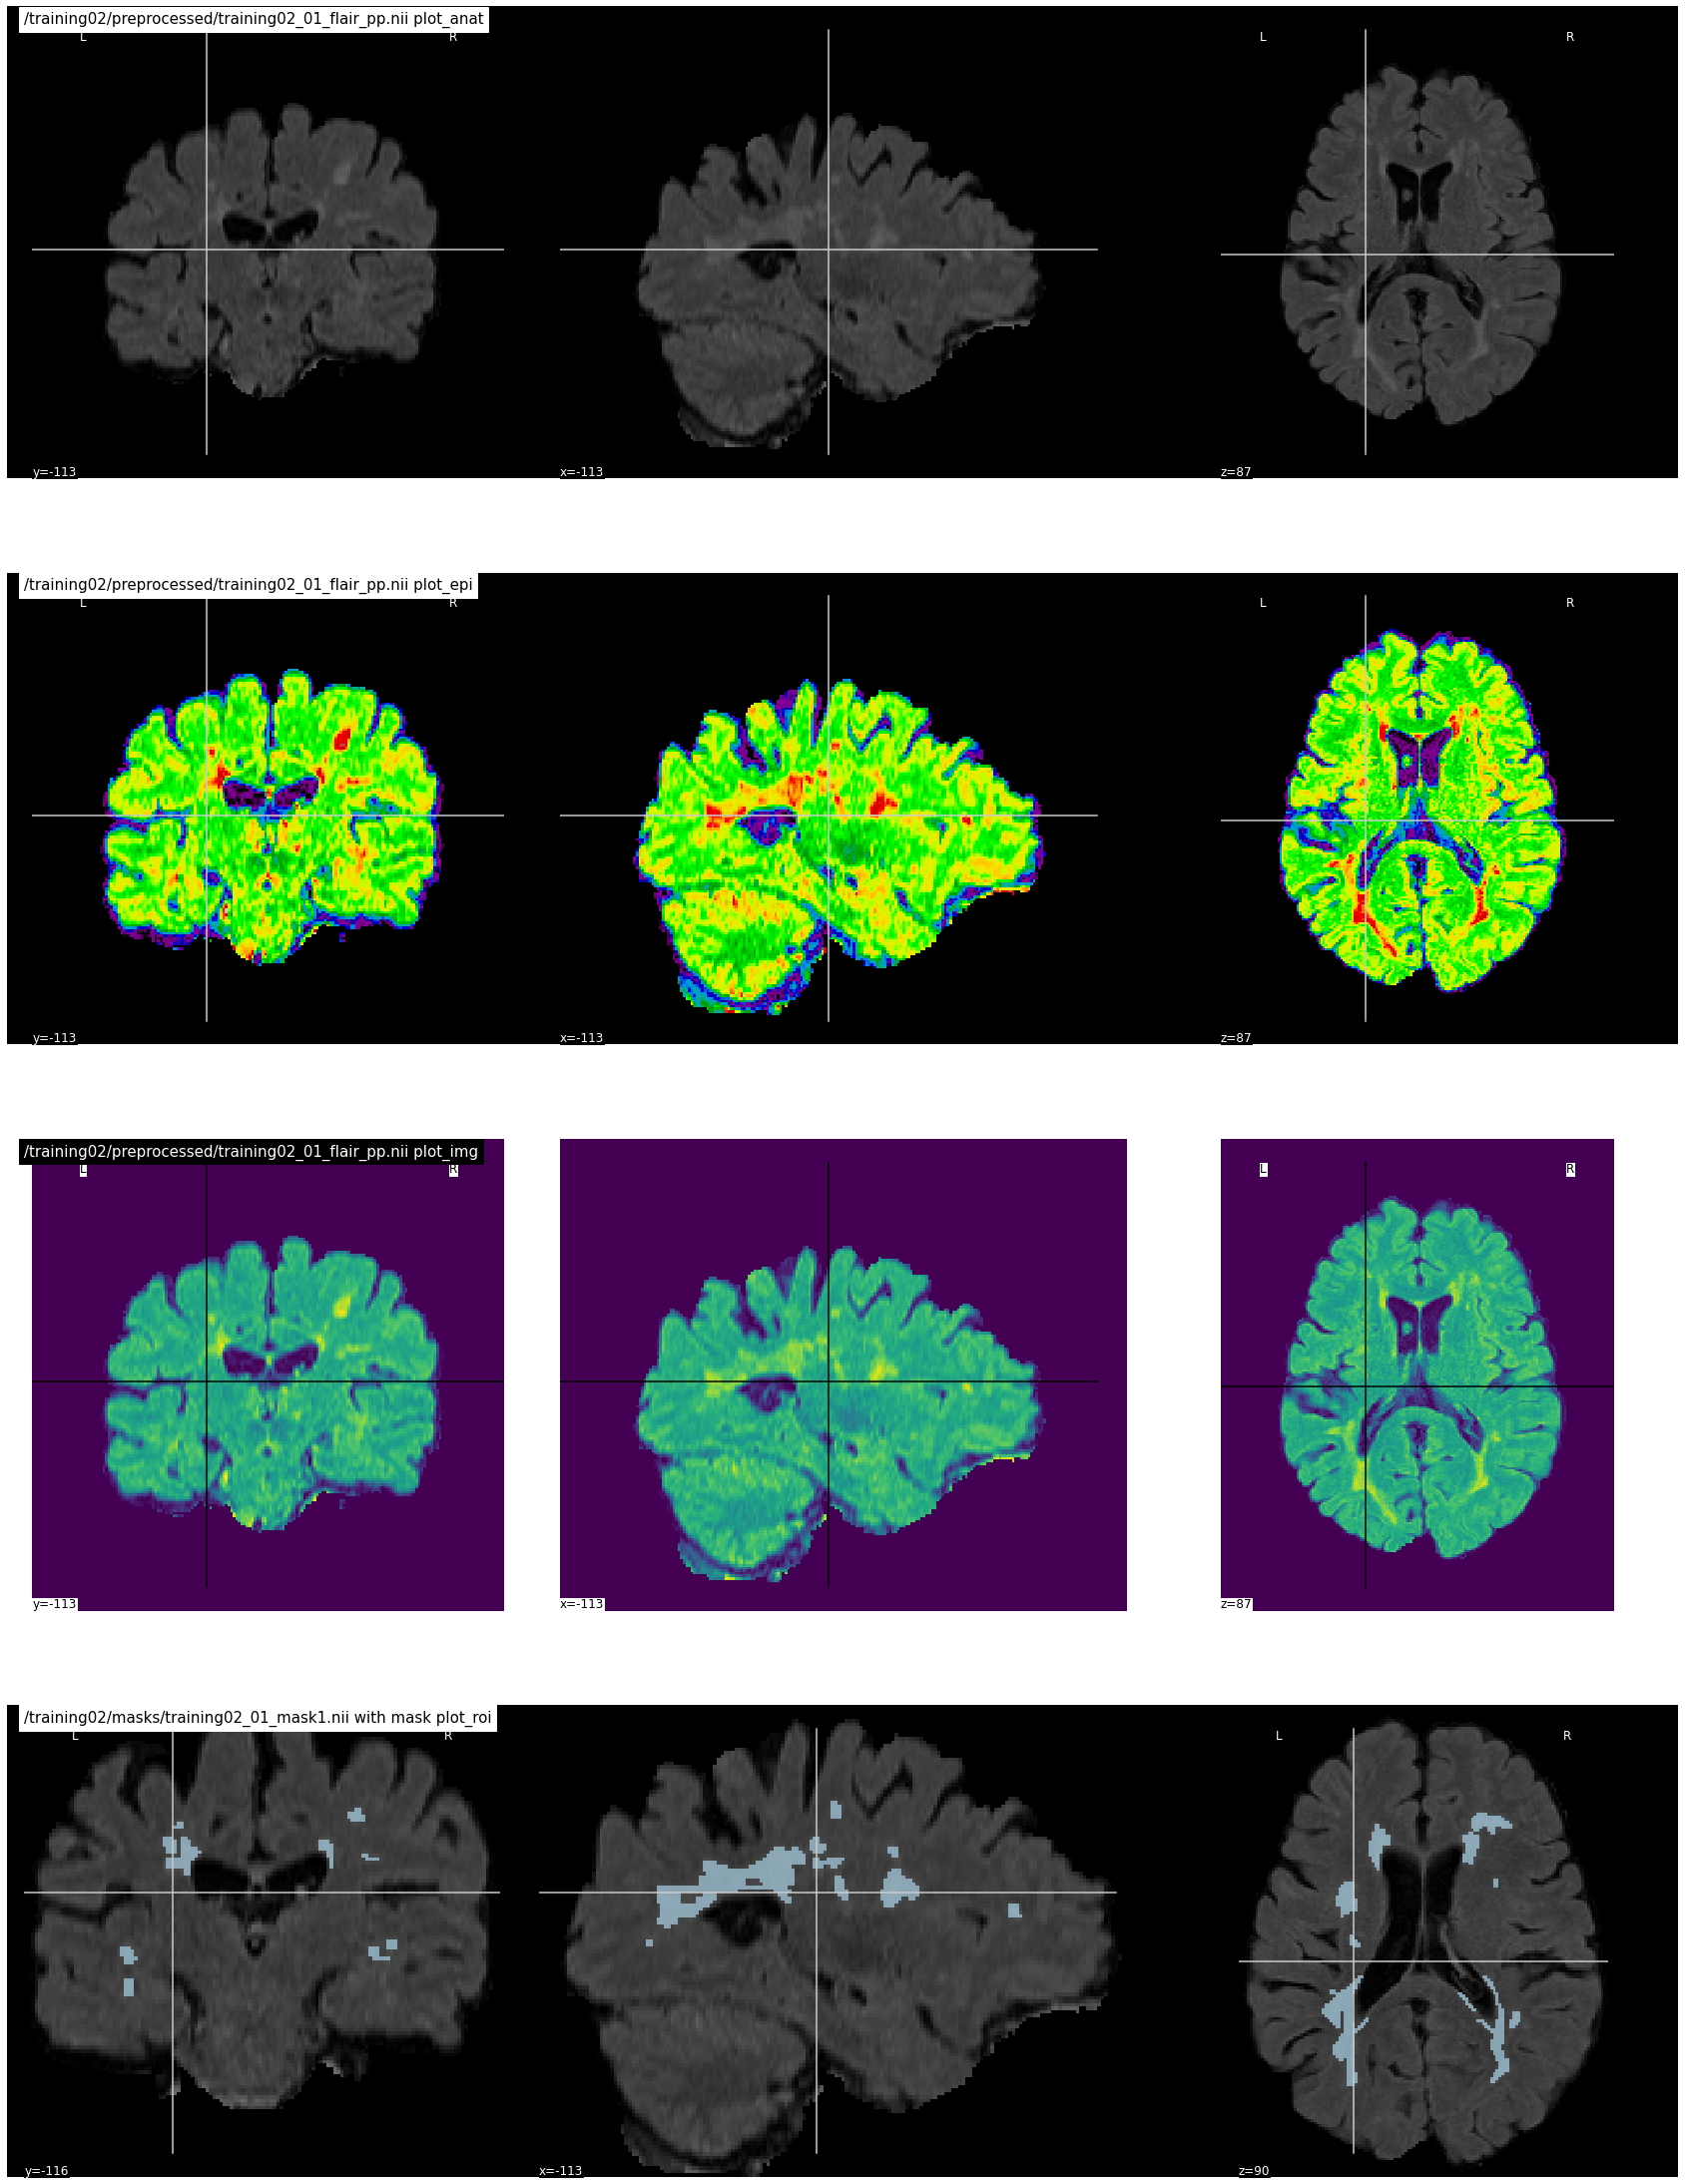

In [6]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + '/training02/preprocessed/training02_01_flair_pp.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + '/training02/masks/training02_01_mask1.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='/training02/preprocessed/training02_01_flair_pp.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='/training02/preprocessed/training02_01_flair_pp.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='/training02/preprocessed/training02_01_flair_pp.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='/training02/masks/training02_01_mask1.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [7]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [8]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [9]:
IMG_SIZE=128

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size =1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
                
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        
        y = np.zeros((self.batch_size*VOLUME_SLICES, 181, 217))   # 240*256
        
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim,2))
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'preprocessed/{i}_01_flair_pp.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'preprocessed/{i}_01_pd_pp.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'preprocessed/{i}_01_mprage_pp.nii');
            seg = nib.load(data_path).get_fdata()
            
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)); 
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));  

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        
        # Generate masks
        y[y==0] = 0;
        
        mask = tf.one_hot(y, 2);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        
        
        return X/np.max(X), Y
    

        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

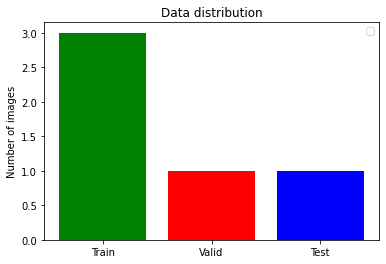

In [11]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

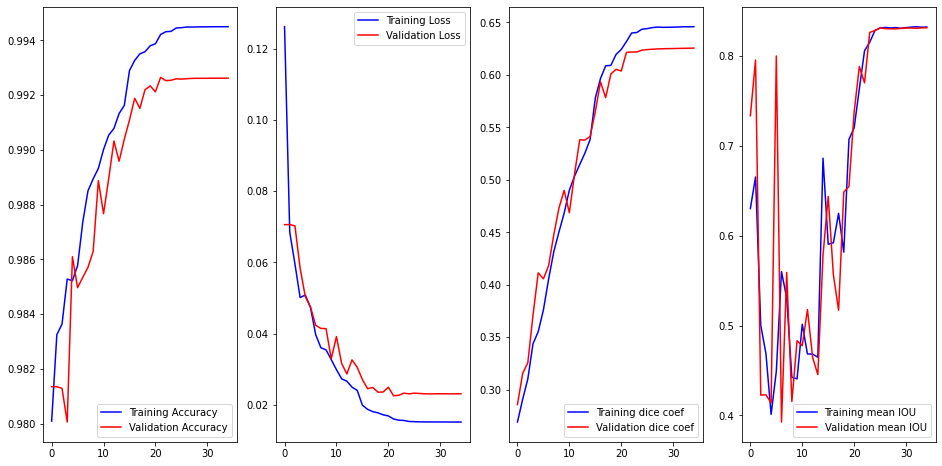

In [12]:
############ load trained model ################

model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)

history = pd.read_csv('../input/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
trunc_model = Model(model.input, model.layers[-2].output)

trunc_model.trainable = False

modified_model = Sequential()
modified_model.add(trunc_model)
modified_model.add(keras.layers.Conv2D(2, (1,1), activation = 'softmax'))

modified_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 128, 128, 32)      7759776   
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 2)       66        
Total params: 7,759,842
Trainable params: 66
Non-trainable params: 7,759,776
_________________________________________________________________


In [15]:
modified_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.2), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,precision, sensitivity, specificity] )

In [16]:
modified_model.fit(training_generator,  
                   epochs=50,
                   validation_data= valid_generator)

Epoch 1/50
3/3 [==============================] - 23s 1s/step - loss: 3.5785 - accuracy: 0.1505 - mean_io_u_1: 0.2933 - dice_coef: 0.0165 - precision: 5.8096e-05 - sensitivity: 6.9951e-05 - specificity: 0.1426 - val_loss: 3.5230 - val_accuracy: 0.1134 - val_mean_io_u_1: 0.2881 - val_dice_coef: 0.0195 - val_precision: 7.8668e-05 - val_sensitivity: 9.2173e-05 - val_specificity: 0.1267
Epoch 2/50
3/3 [==============================] - 1s 439ms/step - loss: 3.3962 - accuracy: 0.1522 - mean_io_u_1: 0.2933 - dice_coef: 0.0200 - precision: 8.1154e-05 - sensitivity: 9.7734e-05 - specificity: 0.1426 - val_loss: 3.3345 - val_accuracy: 0.1159 - val_mean_io_u_1: 0.2881 - val_dice_coef: 0.0237 - val_precision: 1.0173e-04 - val_sensitivity: 1.1919e-04 - val_specificity: 0.1267
Epoch 3/50
3/3 [==============================] - 1s 419ms/step - loss: 3.2138 - accuracy: 0.1539 - mean_io_u_1: 0.2933 - dice_coef: 0.0242 - precision: 1.1551e-04 - sensitivity: 1.3899e-04 - specificity: 0.1427 - val_loss: 3.

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
U_net= modified_model.evaluate(test_generator)
print("test loss, test acc:", U_net)

Evaluate on test data
1/1 [==============================] - 0s 434ms/step - loss: 0.2213 - accuracy: 0.9433 - mean_io_u_1: 0.2968 - dice_coef: 0.3949 - precision: 0.7611 - sensitivity: 0.9305 - specificity: 0.7986
test loss, test acc: [0.22131188213825226, 0.9433498978614807, 0.296846866607666, 0.39486005902290344, 0.7610588669776917, 0.930505633354187, 0.7986047863960266]


In [18]:
modified_model.save('D:\segmentaion_model.h5')

In [19]:
modified_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 128, 128, 32)      7759776   
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 2)       66        
Total params: 7,759,842
Trainable params: 66
Non-trainable params: 7,759,776
_________________________________________________________________


In [28]:
MS = modified_model.predict(test_generator)

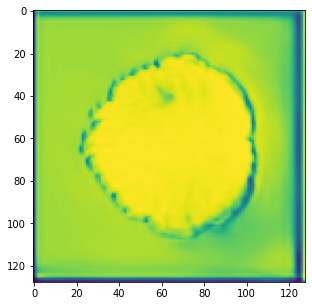

In [32]:
fig = plt.figure(figsize=(5,5))
immmg = MS[30,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

In [41]:
def show_image(images):
    # show image with [None, None, : ,: ,:] dimension
    def show_frame(id):
        length = len(images)
        for i in range(length):
            ax = plt.subplot(1, length, i+1)
            if (i == 0):
                ax.set_title("Input")
            if (i == 1):
                ax.set_title("Target")
            if (i == 2):
                ax.set_title("Output")
            plt.imshow(images[i][id, :, :], cmap='gray')
    interact(show_frame, 
             id=widgets.IntSlider(min=0, max=images[0].shape[0]-1, step=1, value=images[0].shape[0]/2))
    
    plt.show()

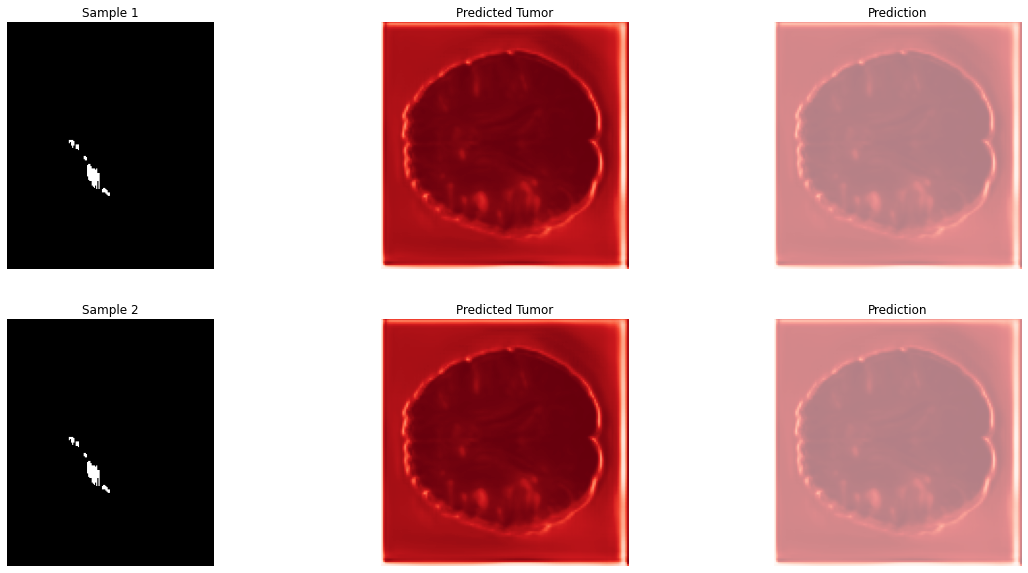

In [73]:
plt.figure(figsize=(20,10))


plt.subplot(231)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(test_image_Brain_Mask[50,:,:]),cmap='gray')


plt.subplot(232)
plt.title('Predicted Tumor')
plt.axis('off')
plt.imshow(np.squeeze(MS[5,:,:,0]),cmap='Reds')

plt.subplot(233)
plt.title('Prediction')
plt.axis('off')
#plt.imshow(np.squeeze(test_image_Brain_Mask[50,:,:]),cmap='gray')
plt.imshow(np.squeeze(MS[5,:,:,0]),alpha = 0.5,cmap='Reds')


plt.subplot(234)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(test_image_Brain_Mask[50,:,:]),cmap='gray')


plt.subplot(235)
plt.title('Predicted Tumor')
plt.axis('off')
plt.imshow(np.squeeze(MS[5,:,:,0]),cmap='Reds')

plt.subplot(236)
plt.title('Prediction')
plt.axis('off')
#plt.imshow(np.squeeze(test_image_Brain_Mask[50,:,:]),cmap='gray')
plt.imshow(np.squeeze(MS[5,:,:,0]),alpha = 0.5, cmap='Reds')